dataanalyse

In [9]:
import os
import sys
spark_name = os.environ.get('SPARK_HOME',None)
if not spark_name:
    raise ValueErrorError('spark环境没有配置好')
sys.path.insert(0,os.path.join(spark_name,'python'))
sys.path.insert(0,os.path.join(spark_name,'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_name,'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/

Using Python version 3.9.12 (main, Apr  4 2022 05:22:27)
Spark context Web UI available at http://jelly:4041
Spark context available as 'sc' (master = local[*], app id = local-1671623411546).
SparkSession available as 'spark'.


In [10]:
import findspark
findspark.init()
import pyspark
print("successful")
import warnings#忽略版本等警告
warnings.filterwarnings("ignore")

successful


In [11]:
from pyspark.sql import SparkSession
# 构建SparkSession执行环境入口对象
spark = SparkSession.builder. \
    appName('bigdata preana'). \
    master('local'). \
    getOrCreate()
sc = spark.sparkContext

读取数据表

In [12]:
dfread = spark.read.format('csv'). \
    option('sep', ','). \
        option('header', True). \
            option('encoding', 'GBK'). \
                load('D:\pycharm\pysparkProject_work\\bigdata_base\data\matches.csv',
                     inferSchema=True)
print('Total Records = {}'.format(dfread.count()))
dfread = dfread.selectExpr("_c0 as index","*").drop("_c0")
print(type(dfread))
dfread.show(10)

Total Records = 9226
<class 'pyspark.sql.dataframe.DataFrame'>
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|    0|  0|         0|         0|             0|         0|          0|              0|         0|             0|         0|          0|              0|   na1|
|    1|  1|         1|         1|             0|         0|          1|              0|         1|             0|         0|          2|              0|   na1|
|    2|  0|         0|         0|             0|         0|          0|              0|         0|             0|         0|          0| 

原表描述统计

In [13]:
dfread.drop('index').describe().show()

+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------+
|summary|               win|         firstBlood|        firstTower|     firstInhibitor|         firstBaron|        firstDragon|   firstRiftHerald|        towerKills|    inhibitorKills|        baronKills|       dragonKills|   riftHeraldKills|region|
+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------+
|  count|              9226|               9226|              9226|               9226|               9226|               9226|              9226|              9226|              9226|              9226|              9226|              9226|  9226|
|   

In [9]:
dfread.drop('index', 'win','firstBlood', 'firstTower',
                    'firstInhibitor','firstBaron','firstDragon',
                    'firstRiftHerald').describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+------+
|summary|        towerKills|    inhibitorKills|        baronKills|       dragonKills|   riftHeraldKills|region|
+-------+------------------+------------------+------------------+------------------+------------------+------+
|  count|              9226|              9226|              9226|              9226|              9226|  9226|
|   mean| 4.611207457186213|0.6845870366355951|0.3639713852156948| 1.554194667244743|0.7000867114675916|  null|
| stddev|3.4131008741494084| 0.957760954646272|0.5835861555207791|1.3406062886946142|0.7380586804492858|  null|
|    min|                 0|                 0|                 0|                 0|                 0|   br1|
|    max|                11|                 7|                 3|                 5|                 2|   na1|
+-------+------------------+------------------+------------------+------------------+------------------+

统计每行数据缺失率

In [13]:
import pyspark.sql.functions as F
dfread.agg(
    *[(1 - (F.count(c)/F.count('*'))).alias(c + 'missing') for c in dfread.columns]
).show()

+------------+----------+-----------------+-----------------+---------------------+-----------------+------------------+----------------------+-----------------+---------------------+-----------------+------------------+----------------------+-------------+
|indexmissing|winmissing|firstBloodmissing|firstTowermissing|firstInhibitormissing|firstBaronmissing|firstDragonmissing|firstRiftHeraldmissing|towerKillsmissing|inhibitorKillsmissing|baronKillsmissing|dragonKillsmissing|riftHeraldKillsmissing|regionmissing|
+------------+----------+-----------------+-----------------+---------------------+-----------------+------------------+----------------------+-----------------+---------------------+-----------------+------------------+----------------------+-------------+
|         0.0|       0.0|              0.0|              0.0|                  0.0|              0.0|               0.0|                   0.0|              0.0|                  0.0|              0.0|               0.0|      

查找每行缺失的数据

a = dfread.rdd.map(lambda row: (row[0], sum([c == None for c in row]))).collect()
print(a)

空值可视化

<AxesSubplot:>

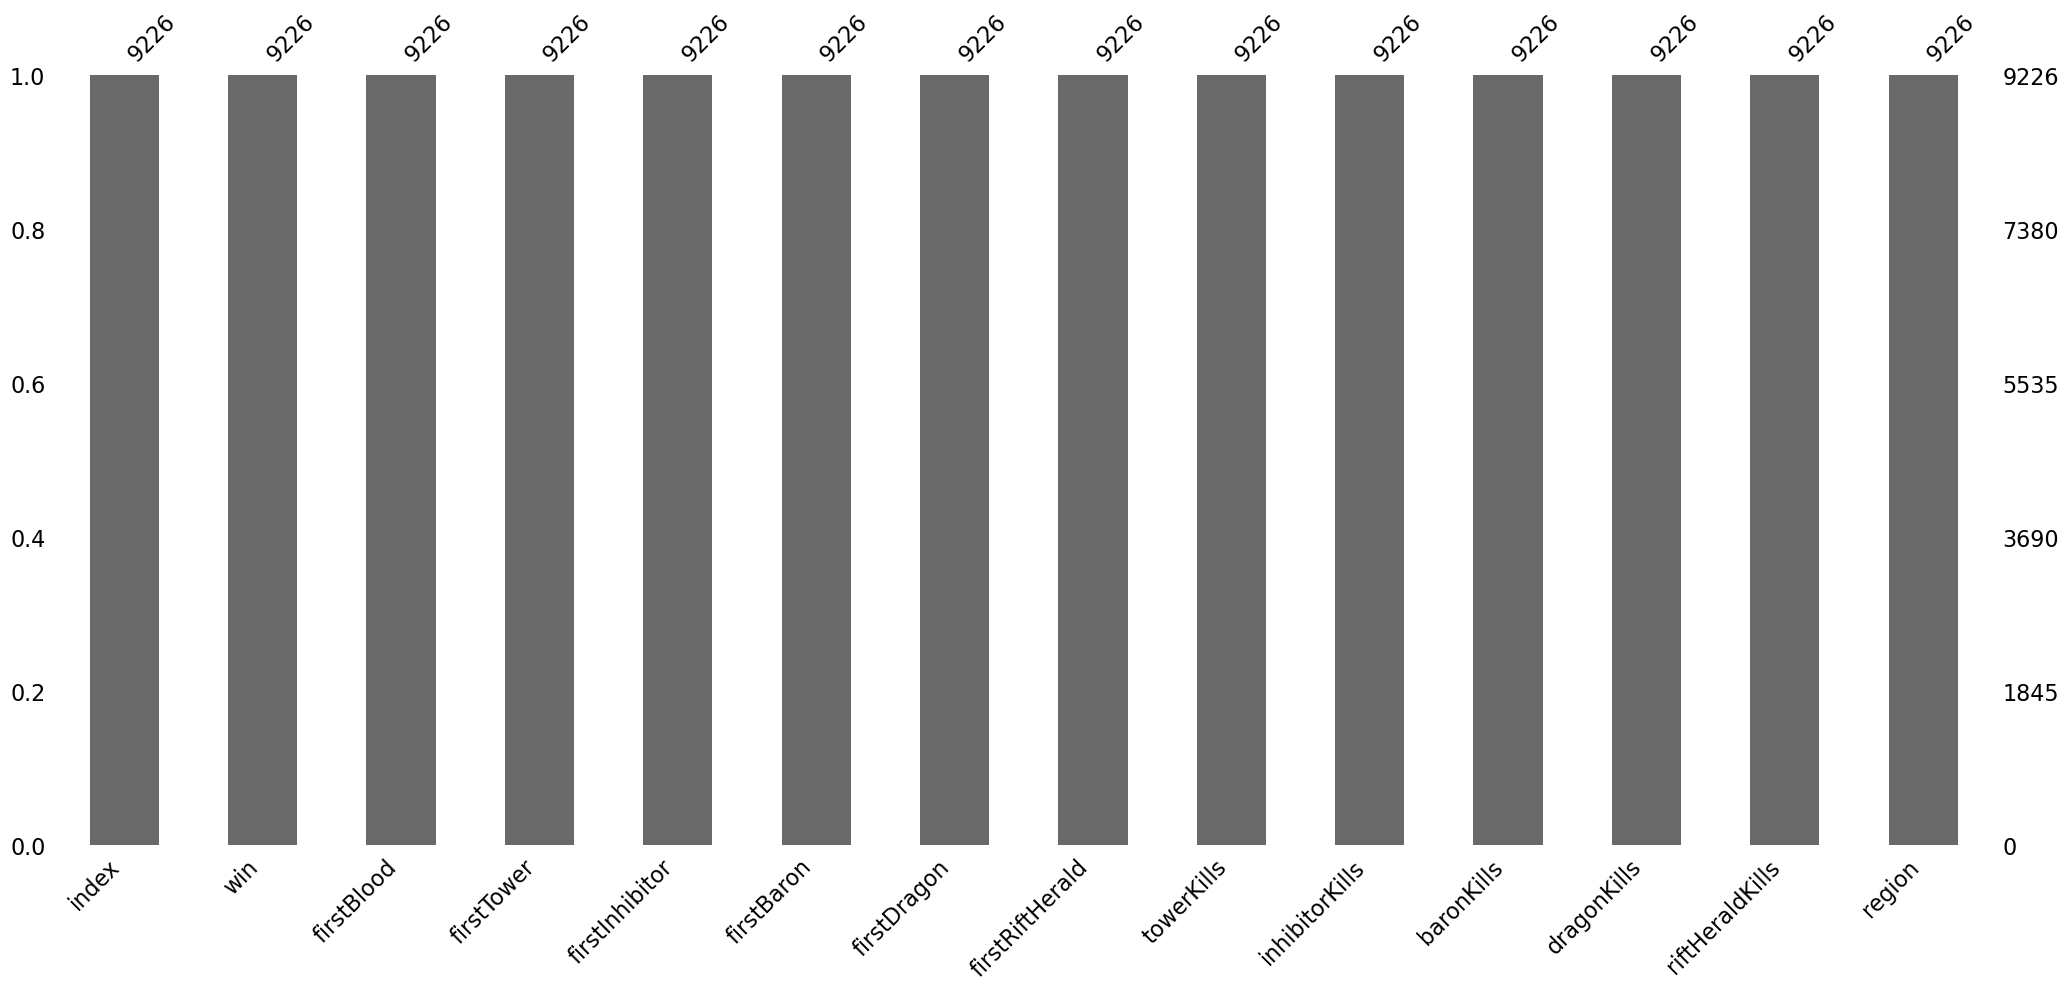

In [22]:
import missingno as mg
mg.bar(dfread.toPandas(),labels=1)

In [42]:
#更改列的数据类型
dfread = dfread.withColumn("towerKills",dfread['towerKills'].astype("int")).\
    withColumn("inhibitorKills",dfread['inhibitorKills'].astype("int")).\
    withColumn("baronKills",dfread['baronKills'].astype("int")).\
   withColumn("dragonKills",dfread['dragonKills'].astype("int")).\
withColumn("riftHeraldKills",dfread['riftHeraldKills'].astype("int"))
dfread.printSchema()

root
 |-- index: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- firstBlood: integer (nullable = true)
 |-- firstTower: integer (nullable = true)
 |-- firstInhibitor: integer (nullable = true)
 |-- firstBaron: integer (nullable = true)
 |-- firstDragon: integer (nullable = true)
 |-- firstRiftHerald: integer (nullable = true)
 |-- towerKills: integer (nullable = true)
 |-- inhibitorKills: integer (nullable = true)
 |-- baronKills: integer (nullable = true)
 |-- dragonKills: integer (nullable = true)
 |-- riftHeraldKills: integer (nullable = true)
 |-- region: string (nullable = true)



In [28]:
#分组统计#地区选手比例
print(type(dfread['region']))
partition = dfread.groupby('region').count().show()

<class 'pyspark.sql.column.Column'>
+------+-----+
|region|count|
+------+-----+
|  euw1| 1672|
|  eun1| 1772|
|   na1| 1938|
|    kr| 1994|
|   br1| 1850|
+------+-----+



In [14]:
import seaborn as sns
df01 = dfread.select('win','firstBlood', 'firstTower',
                    'firstInhibitor','firstBaron','firstDragon',
                    'firstRiftHerald')
dfseries = dfread.select('towerKills','inhibitorKills',
                    'baronKills','dragonKills','riftHeraldKills','region')
df01.show()
dfseries.show()


+---+----------+----------+--------------+----------+-----------+---------------+
|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|
+---+----------+----------+--------------+----------+-----------+---------------+
|  0|         0|         0|             0|         0|          0|              0|
|  1|         1|         1|             0|         0|          1|              0|
|  0|         0|         0|             0|         0|          0|              0|
|  1|         1|         1|             1|         0|          1|              1|
|  1|         1|         1|             1|         0|          1|              0|
|  0|         0|         0|             0|         0|          0|              0|
|  1|         1|         1|             0|         1|          1|              1|
|  0|         0|         0|             0|         0|          0|              0|
|  1|         1|         0|             0|         1|          0|              0|
|  0|         0|

In [47]:
#检查重复数据
print('Count of rows: {0}'.format(dfread.count()))
print('Count of distinct rows: {0}'.format(dfread.distinct().count()))


Count of rows: 9226
Count of distinct rows: 9226


检查异常值

Text(0, 0.5, 'values of win by region')

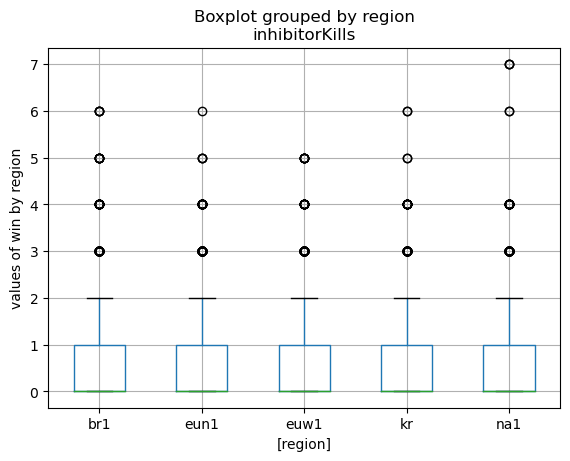

In [62]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='inhibitorKills',by=['region'],ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

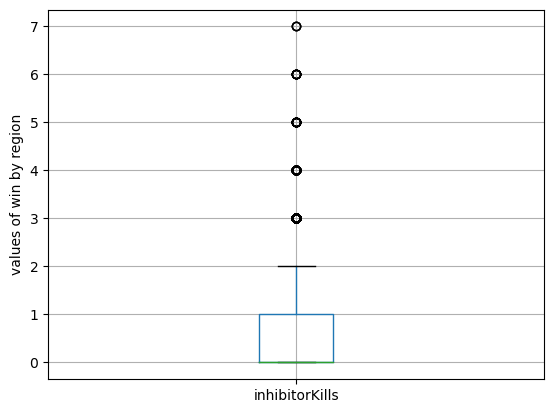

In [61]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='inhibitorKills',ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

In [64]:
dfread.orderBy(
    ['inhibitorKills'],ascending=0).show()

+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|   94|  1|         1|         1|             1|         0|          0|              1|        11|             7|         1|          2|              2|   na1|
| 1560|  1|         1|         1|             1|         0|          0|              1|        11|             7|         1|          2|              2|   na1|
|  498|  1|         1|         1|             1|         0|          0|              1|        11|             7|         1|          2|              2|   na1|
| 2495|  1|         1|         1|       

Text(0, 0.5, 'values of win by region')

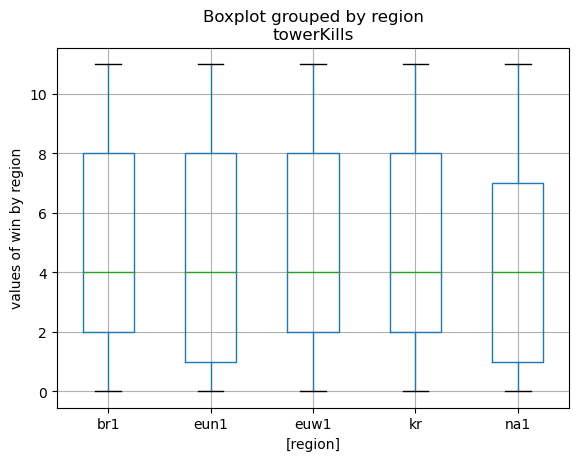

In [65]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='towerKills',by=['region'],ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

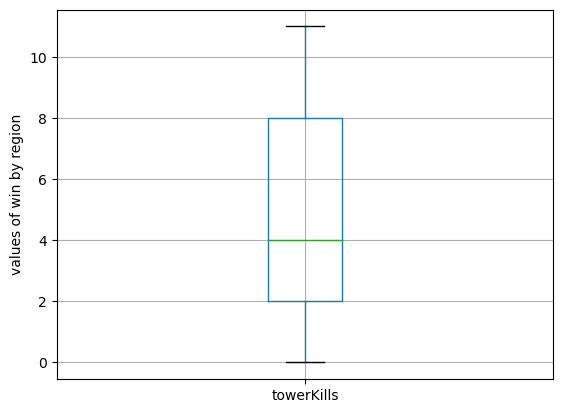

In [66]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='towerKills',ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

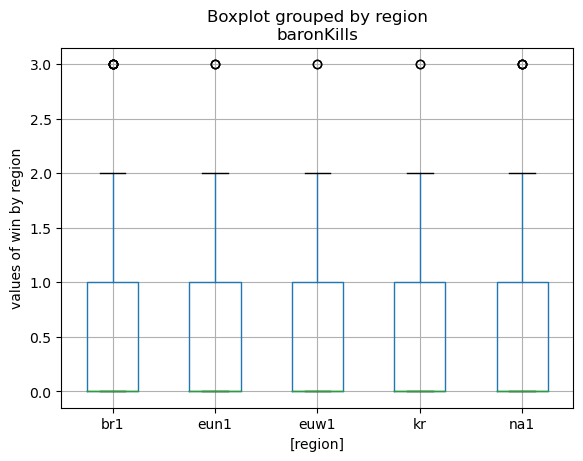

In [69]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='baronKills',by=['region'],ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

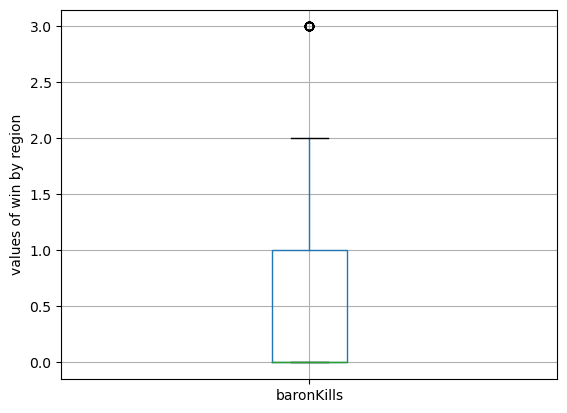

In [70]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='baronKills',ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

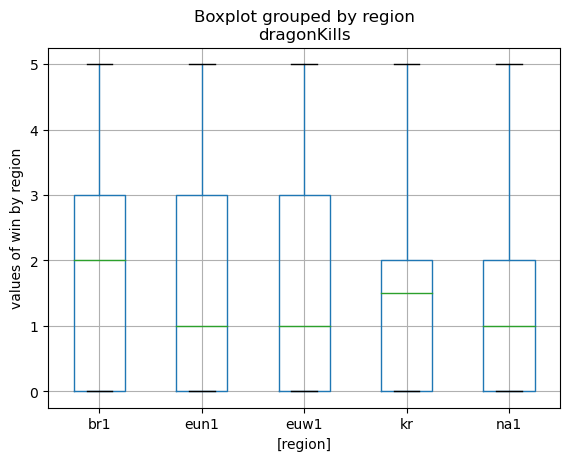

In [71]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='dragonKills',by=['region'],ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

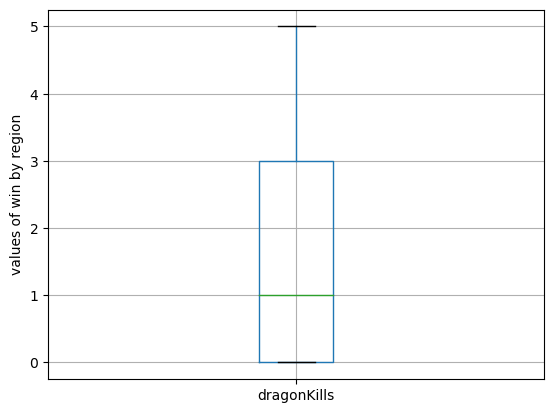

In [72]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='dragonKills',ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

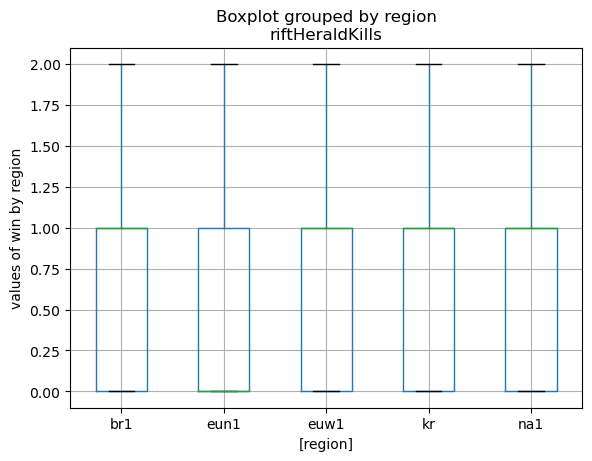

In [73]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='riftHeraldKills',by=['region'],ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

Text(0, 0.5, 'values of win by region')

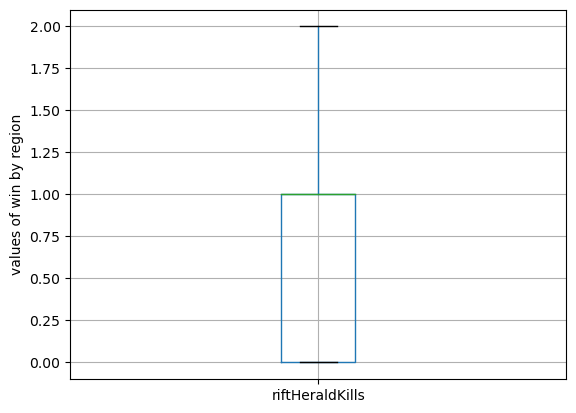

In [74]:
fig,axes = plt.subplots()
dfread.toPandas().boxplot(column='riftHeraldKills',ax=axes)
# column参数表示要绘制成箱形图的数据，可以是一列或多列
# by参数表示分组依据
axes.set_ylabel('values of win by region')

In [79]:
# dfread.orderBy(
#     ['baronKills'],ascending=0).show()
dfread.registerTempTable("dfread_tmp")#生成临时表
sql_tmp = "select count(*) from dfread_tmp WHERE dfread_tmp.baronKills=3"
baronkill_3_count = spark.sql(sql_tmp)
baronkill_3_count.show()

+--------+
|count(1)|
+--------+
|      19|
+--------+



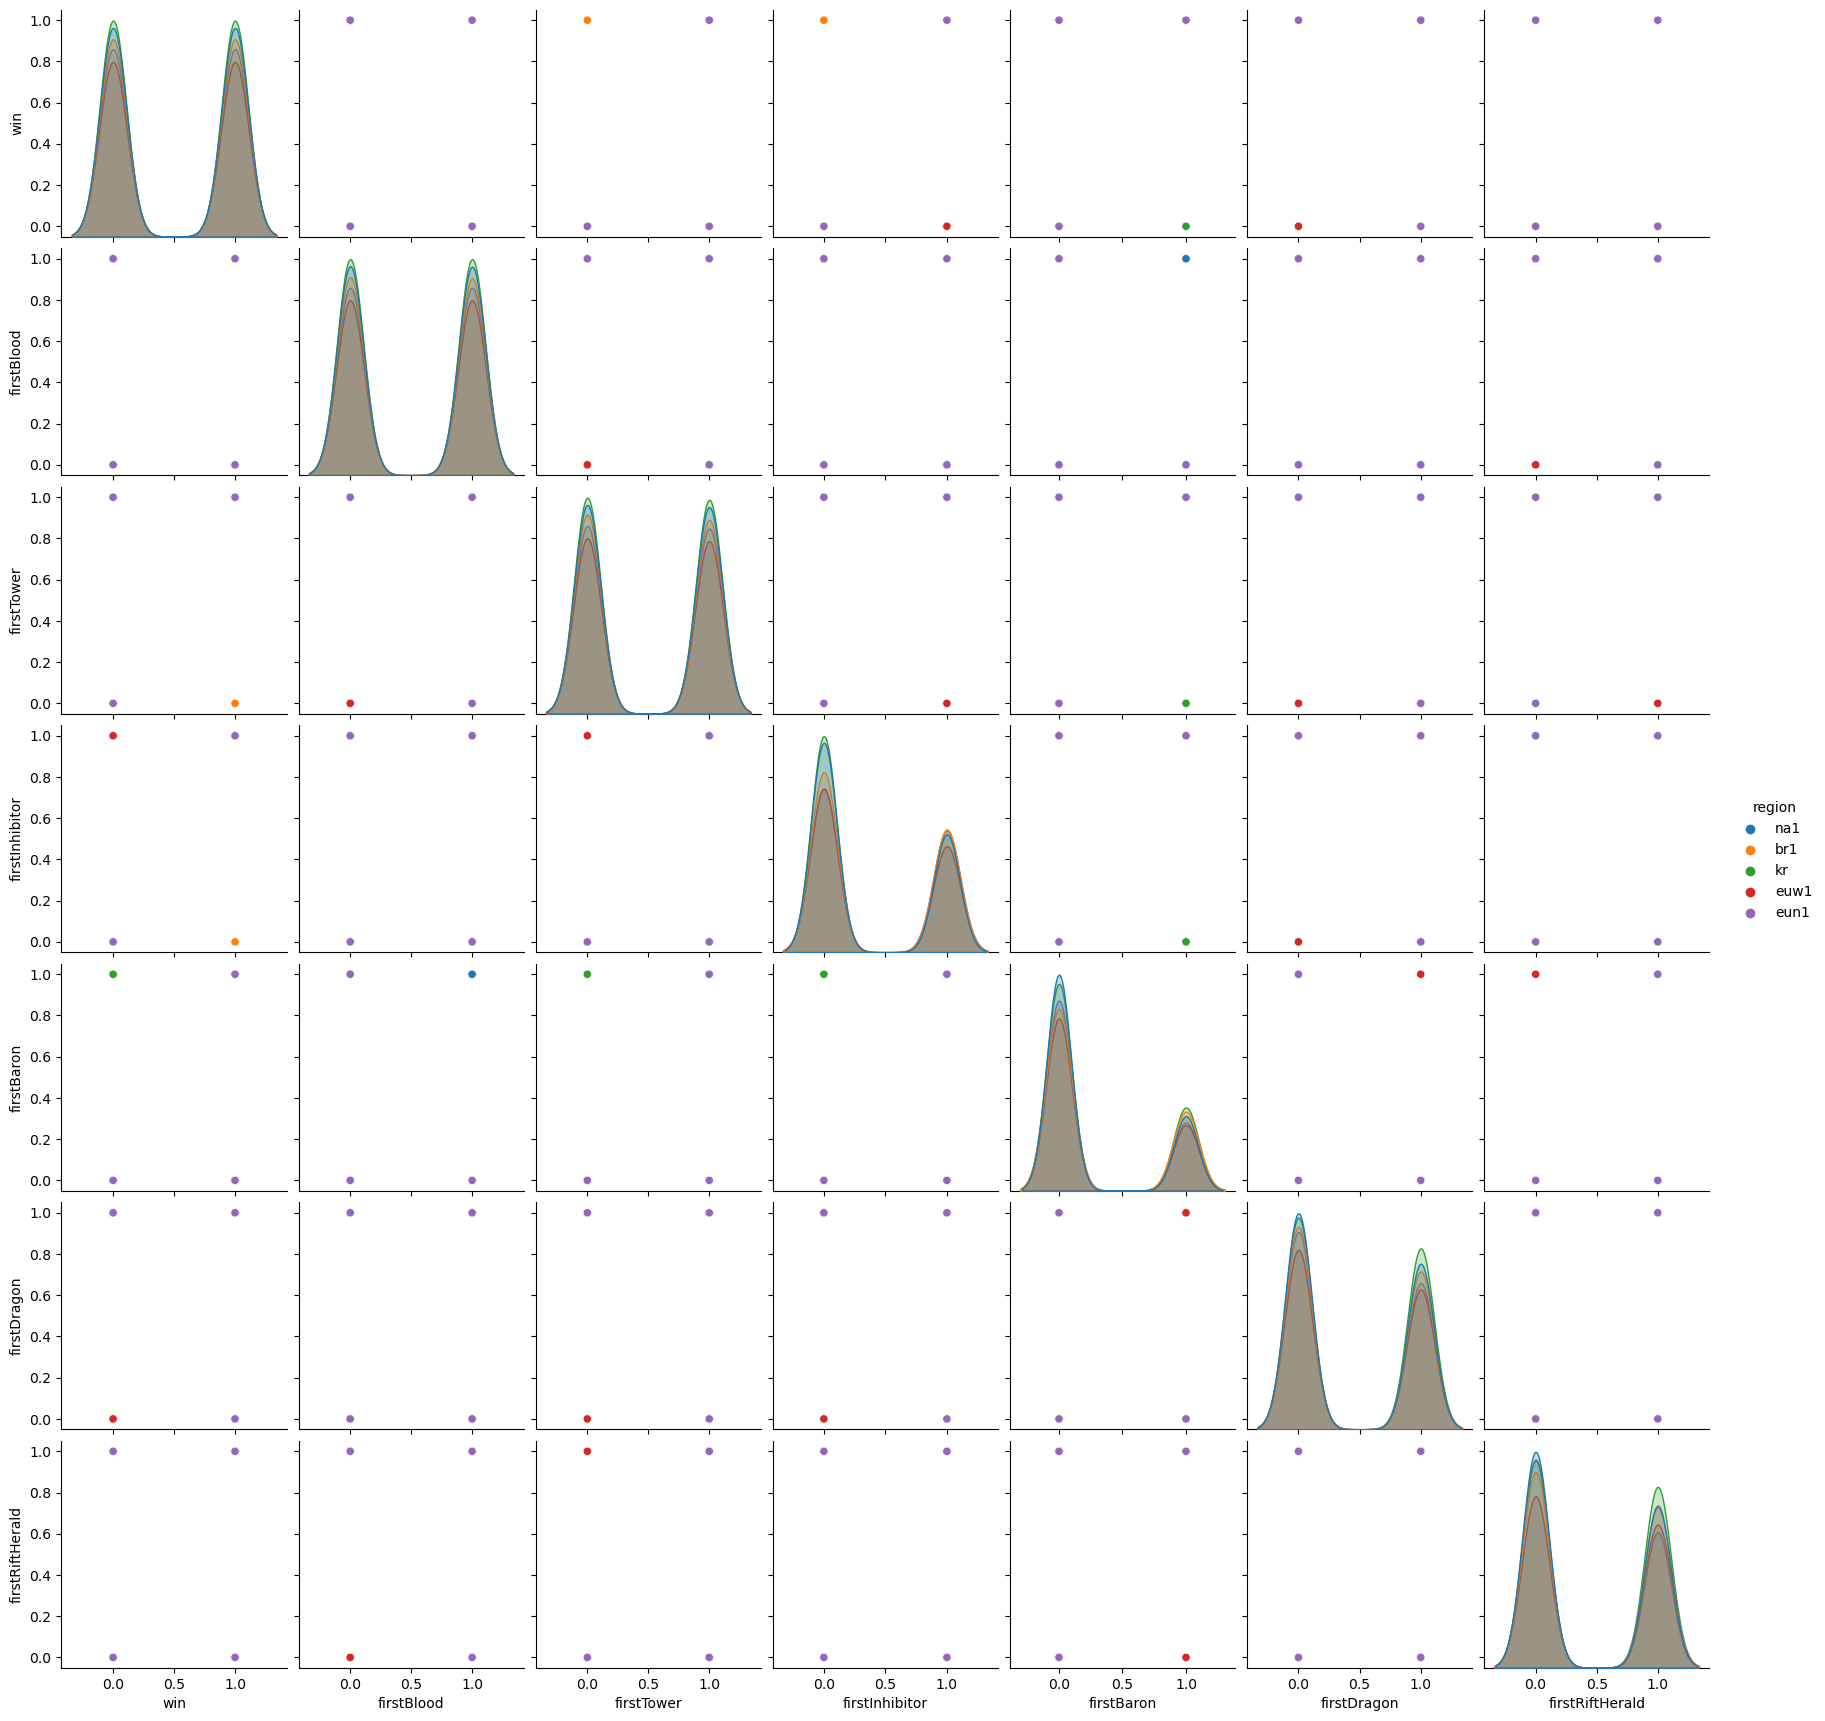

In [87]:
#分别对前7和后5列数据进行pair图分析
import seaborn as sns
df01 = dfread.select('win','firstBlood', 'firstTower',
                    'firstInhibitor','firstBaron','firstDragon',
                    'firstRiftHerald','region')
sns.pairplot(data = df01.toPandas(),height = 2.5,hue = 'region')

In [48]:
print('Total Records before = {}'.format(dfread.count()))
dfread = dfread.dropDuplicates()
dfread.show()
print('Total Records after = {}'.format(dfread.count()))

Total Records before = 9226
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|  468|  1|         1|         1|             0|         0|          1|              0|         1|             0|         0|          2|              0|   na1|
|  550|  1|         1|         0|             1|         0|          1|              1|         6|             1|         0|          2|              2|   na1|
|  741|  1|         1|         1|             1|         0|          1|              1|         6|             1|         0|          2|              1|   na1|
|  798|  0| 

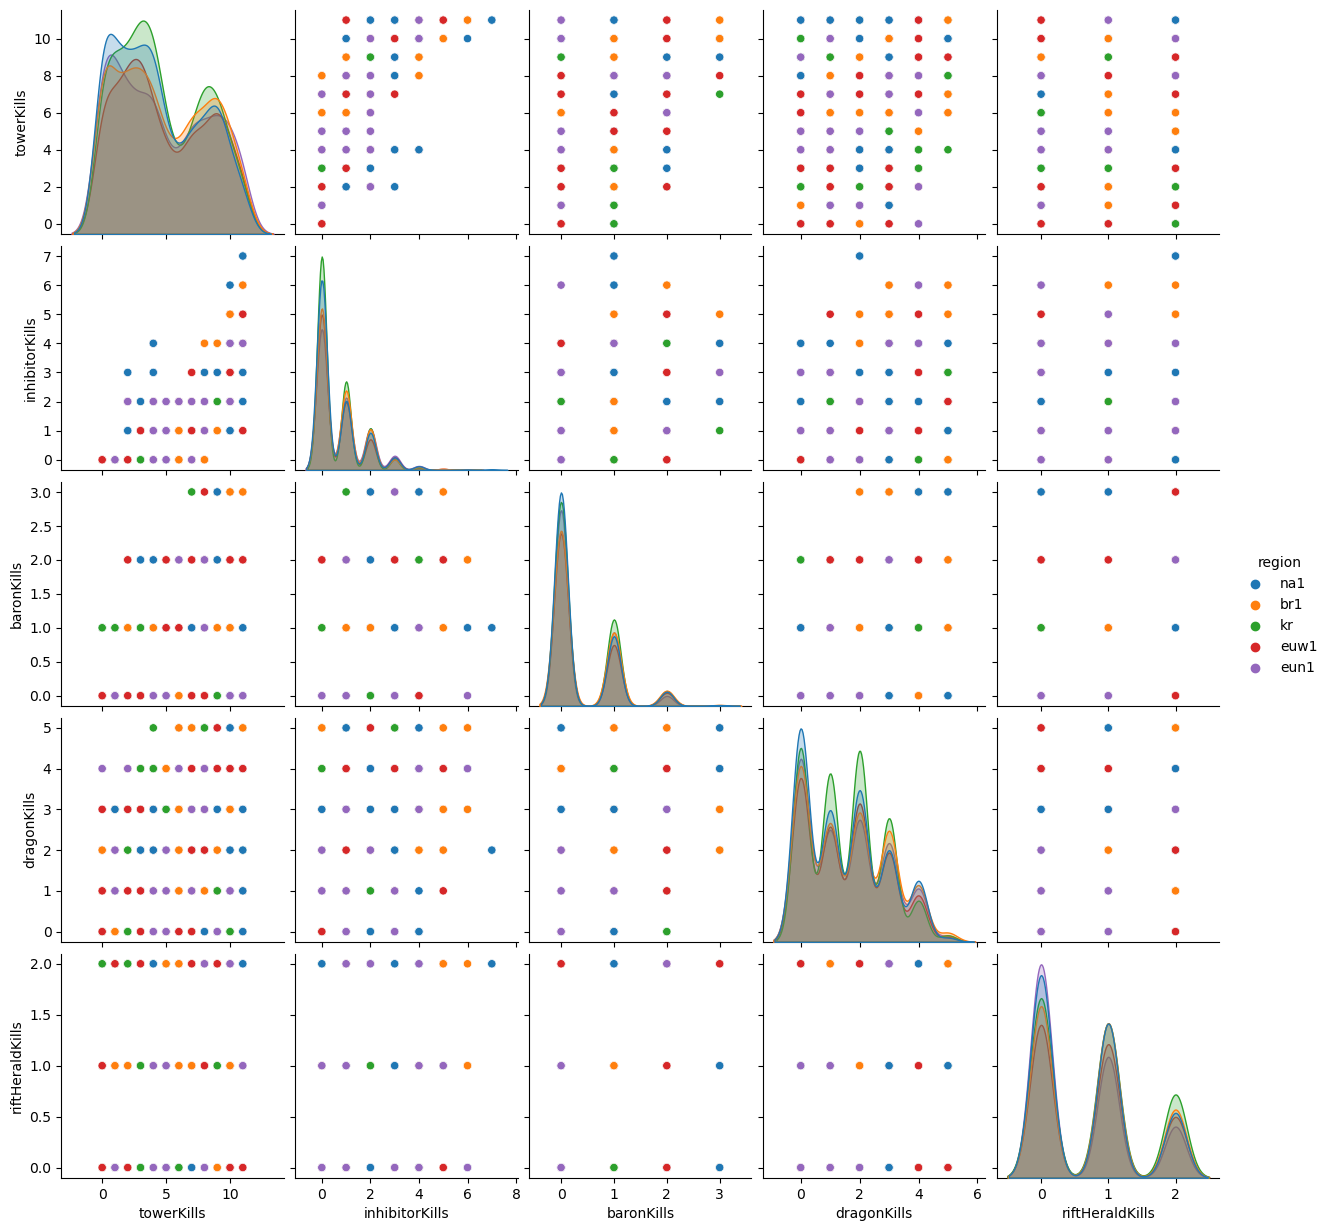

In [86]:
dfseries = dfread.select('towerKills','inhibitorKills',
                    'baronKills','dragonKills','riftHeraldKills','region')
sns.pairplot(data = dfseries.toPandas(),height = 2.5,hue = 'region')

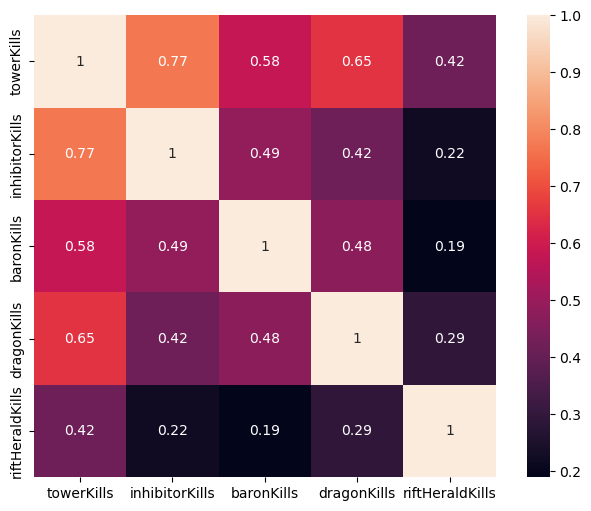

In [99]:
column = dfseries.toPandas().columns.tolist() # 列表头
corr = plt.subplots(figsize = (8,6))
corr= sns.heatmap(dfseries.toPandas()[column].corr(),annot=True,square=True)

In [101]:
dfread = dfread.dropna(how='all',thresh=2)
dfread.show(5)

+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|  468|  1|         1|         1|             0|         0|          1|              0|         1|             0|         0|          2|              0|   na1|
|  550|  1|         1|         0|             1|         0|          1|              1|         6|             1|         0|          2|              2|   na1|
|  741|  1|         1|         1|             1|         0|          1|              1|         6|             1|         0|          2|              1|   na1|
|  798|  0|         1|         0|       

In [111]:
#均值填充
mean_frame = dfread.select(F.avg(dfread['inhibitorKills']))
inhibitorKills_mean = mean_frame.columns[0]
data_fillna = dfread.fillna(inhibitorKills_mean,'inhibitorKills')
data_fillna.show(5)
dfread = data_fillna

+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|  468|  1|         1|         1|             0|         0|          1|              0|         1|             0|         0|          2|              0|   na1|
|  550|  1|         1|         0|             1|         0|          1|              1|         6|             1|         0|          2|              2|   na1|
|  741|  1|         1|         1|             1|         0|          1|              1|         6|             1|         0|          2|              1|   na1|
|  798|  0|         1|         0|       

In [106]:
#缺失值过滤
import numpy as np
dfread.filter(dfread.towerKills != np.nan).filter(dfread.dragonKills != np.nan).show(5)

+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|  468|  1|         1|         1|             0|         0|          1|              0|         1|             0|         0|          2|              0|   na1|
|  550|  1|         1|         0|             1|         0|          1|              1|         6|             1|         0|          2|              2|   na1|
|  741|  1|         1|         1|             1|         0|          1|              1|         6|             1|         0|          2|              1|   na1|
|  798|  0|         1|         0|       

In [24]:
dfseries = dfread.select('index','towerKills','inhibitorKills',
                    'baronKills','dragonKills','riftHeraldKills','region')
dfseries.show(3)

+-----+----------+--------------+----------+-----------+---------------+------+
|index|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+----------+--------------+----------+-----------+---------------+------+
|    0|         0|             0|         0|          0|              0|   na1|
|    1|         1|             0|         0|          2|              0|   na1|
|    2|         0|             0|         0|          0|              0|   na1|
+-----+----------+--------------+----------+-----------+---------------+------+
only showing top 3 rows



In [26]:
from pyspark.ml.feature import VectorAssembler
vecAss = VectorAssembler(inputCols = dfseries.drop('region').columns[1:], outputCol = 'features')
df_featrues = vecAss.transform(dfseries).select('index', 'features')
df_featrues.show(3)

+-----+-------------------+
|index|           features|
+-----+-------------------+
|    0|          (5,[],[])|
|    1|(5,[0,3],[1.0,2.0])|
|    2|          (5,[],[])|
+-----+-------------------+
only showing top 3 rows



In [27]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=['towerKills','inhibitorKills',
                    'baronKills','dragonKills','riftHeraldKills'
], outputCol='features')
 
assembled_data=assemble.transform(dfseries)
assembled_data.show(2)
#向量化

+-----+----------+--------------+----------+-----------+---------------+------+-------------------+
|index|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|           features|
+-----+----------+--------------+----------+-----------+---------------+------+-------------------+
|    0|         0|             0|         0|          0|              0|   na1|          (5,[],[])|
|    1|         1|             0|         0|          2|              0|   na1|(5,[0,3],[1.0,2.0])|
+-----+----------+--------------+----------+-----------+---------------+------+-------------------+
only showing top 2 rows



In [28]:
from pyspark.ml.feature import StandardScaler
 #标准化
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(3)

+-----+----------+--------------+----------+-----------+---------------+------+-------------------+--------------------+
|index|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|           features|        standardized|
+-----+----------+--------------+----------+-----------+---------------+------+-------------------+--------------------+
|    0|         0|             0|         0|          0|              0|   na1|          (5,[],[])|           (5,[],[])|
|    1|         1|             0|         0|          2|              0|   na1|(5,[0,3],[1.0,2.0])|(5,[0,3],[0.29298...|
|    2|         0|             0|         0|          0|              0|   na1|          (5,[],[])|           (5,[],[])|
+-----+----------+--------------+----------+-----------+---------------+------+-------------------+--------------------+
only showing top 3 rows



In [29]:
#test
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
 
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print(" Score:",score)

 Score: 0.5855903767494791
 Score: 0.448547175069244
 Score: 0.4221084587336936
 Score: 0.3960783716367331
 Score: 0.42486840307802226
 Score: 0.44774750783909506
 Score: 0.44607981015077286
 Score: 0.43802374956558343


Text(0, 0.5, 'cost')

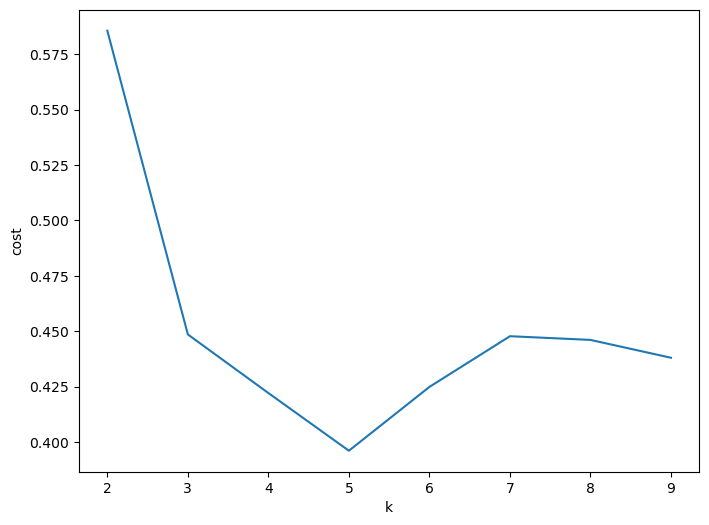

In [30]:
# 可视化轮廓分数
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')
 

In [34]:
#k=6创建模型
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=6, seed=1)
model = kmeans.fit(df_featrues)
centers = model.clusterCenters()

In [35]:
# 获取聚类结果
transformed = model.transform(df_featrues).select('index', 'prediction')
# 合并表格
df_pred = dfseries.join(transformed, 'index')
df_pred.show(5)

+-----+----------+--------------+----------+-----------+---------------+------+----------+
|index|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|prediction|
+-----+----------+--------------+----------+-----------+---------------+------+----------+
|    0|         0|             0|         0|          0|              0|   na1|         5|
|    1|         1|             0|         0|          2|              0|   na1|         5|
|    2|         0|             0|         0|          0|              0|   na1|         5|
|    3|         8|             1|         0|          2|              1|   na1|         3|
|    4|        10|             2|         0|          1|              0|   na1|         3|
+-----+----------+--------------+----------+-----------+---------------+------+----------+
only showing top 5 rows



In [36]:
#聚类中心
kmeans_center = model.clusterCenters()
print(kmeans_center)


[array([2.97295944, 0.41111668, 0.09113671, 0.37656485, 0.57736605]), array([8.90084034, 1.70672269, 0.98907563, 3.61764706, 0.90588235]), array([3.13968548, 0.0120259 , 0.1813136 , 2.40703053, 0.72062905]), array([9.43768769, 1.88138138, 0.76126126, 1.92792793, 1.16591592]), array([6.07261825, 0.62958028, 0.49233844, 2.16189207, 0.9586942 ]), array([0.43952941, 0.        , 0.02352941, 0.408     , 0.21505882])]


In [37]:
#聚类个数
kmeans_add = model.summary.clusterSizes
print(kmeans_add)

[1997, 1190, 1081, 1332, 1501, 2125]


In [38]:
print(type(df_pred))
df_pred.toPandas().to_csv("C:\\Users\\yingm\\Desktop\\bigdatabase\\result_julei.csv",
                             index=False,encoding="GBK",header = True,sep=',')

<class 'pyspark.sql.dataframe.DataFrame'>


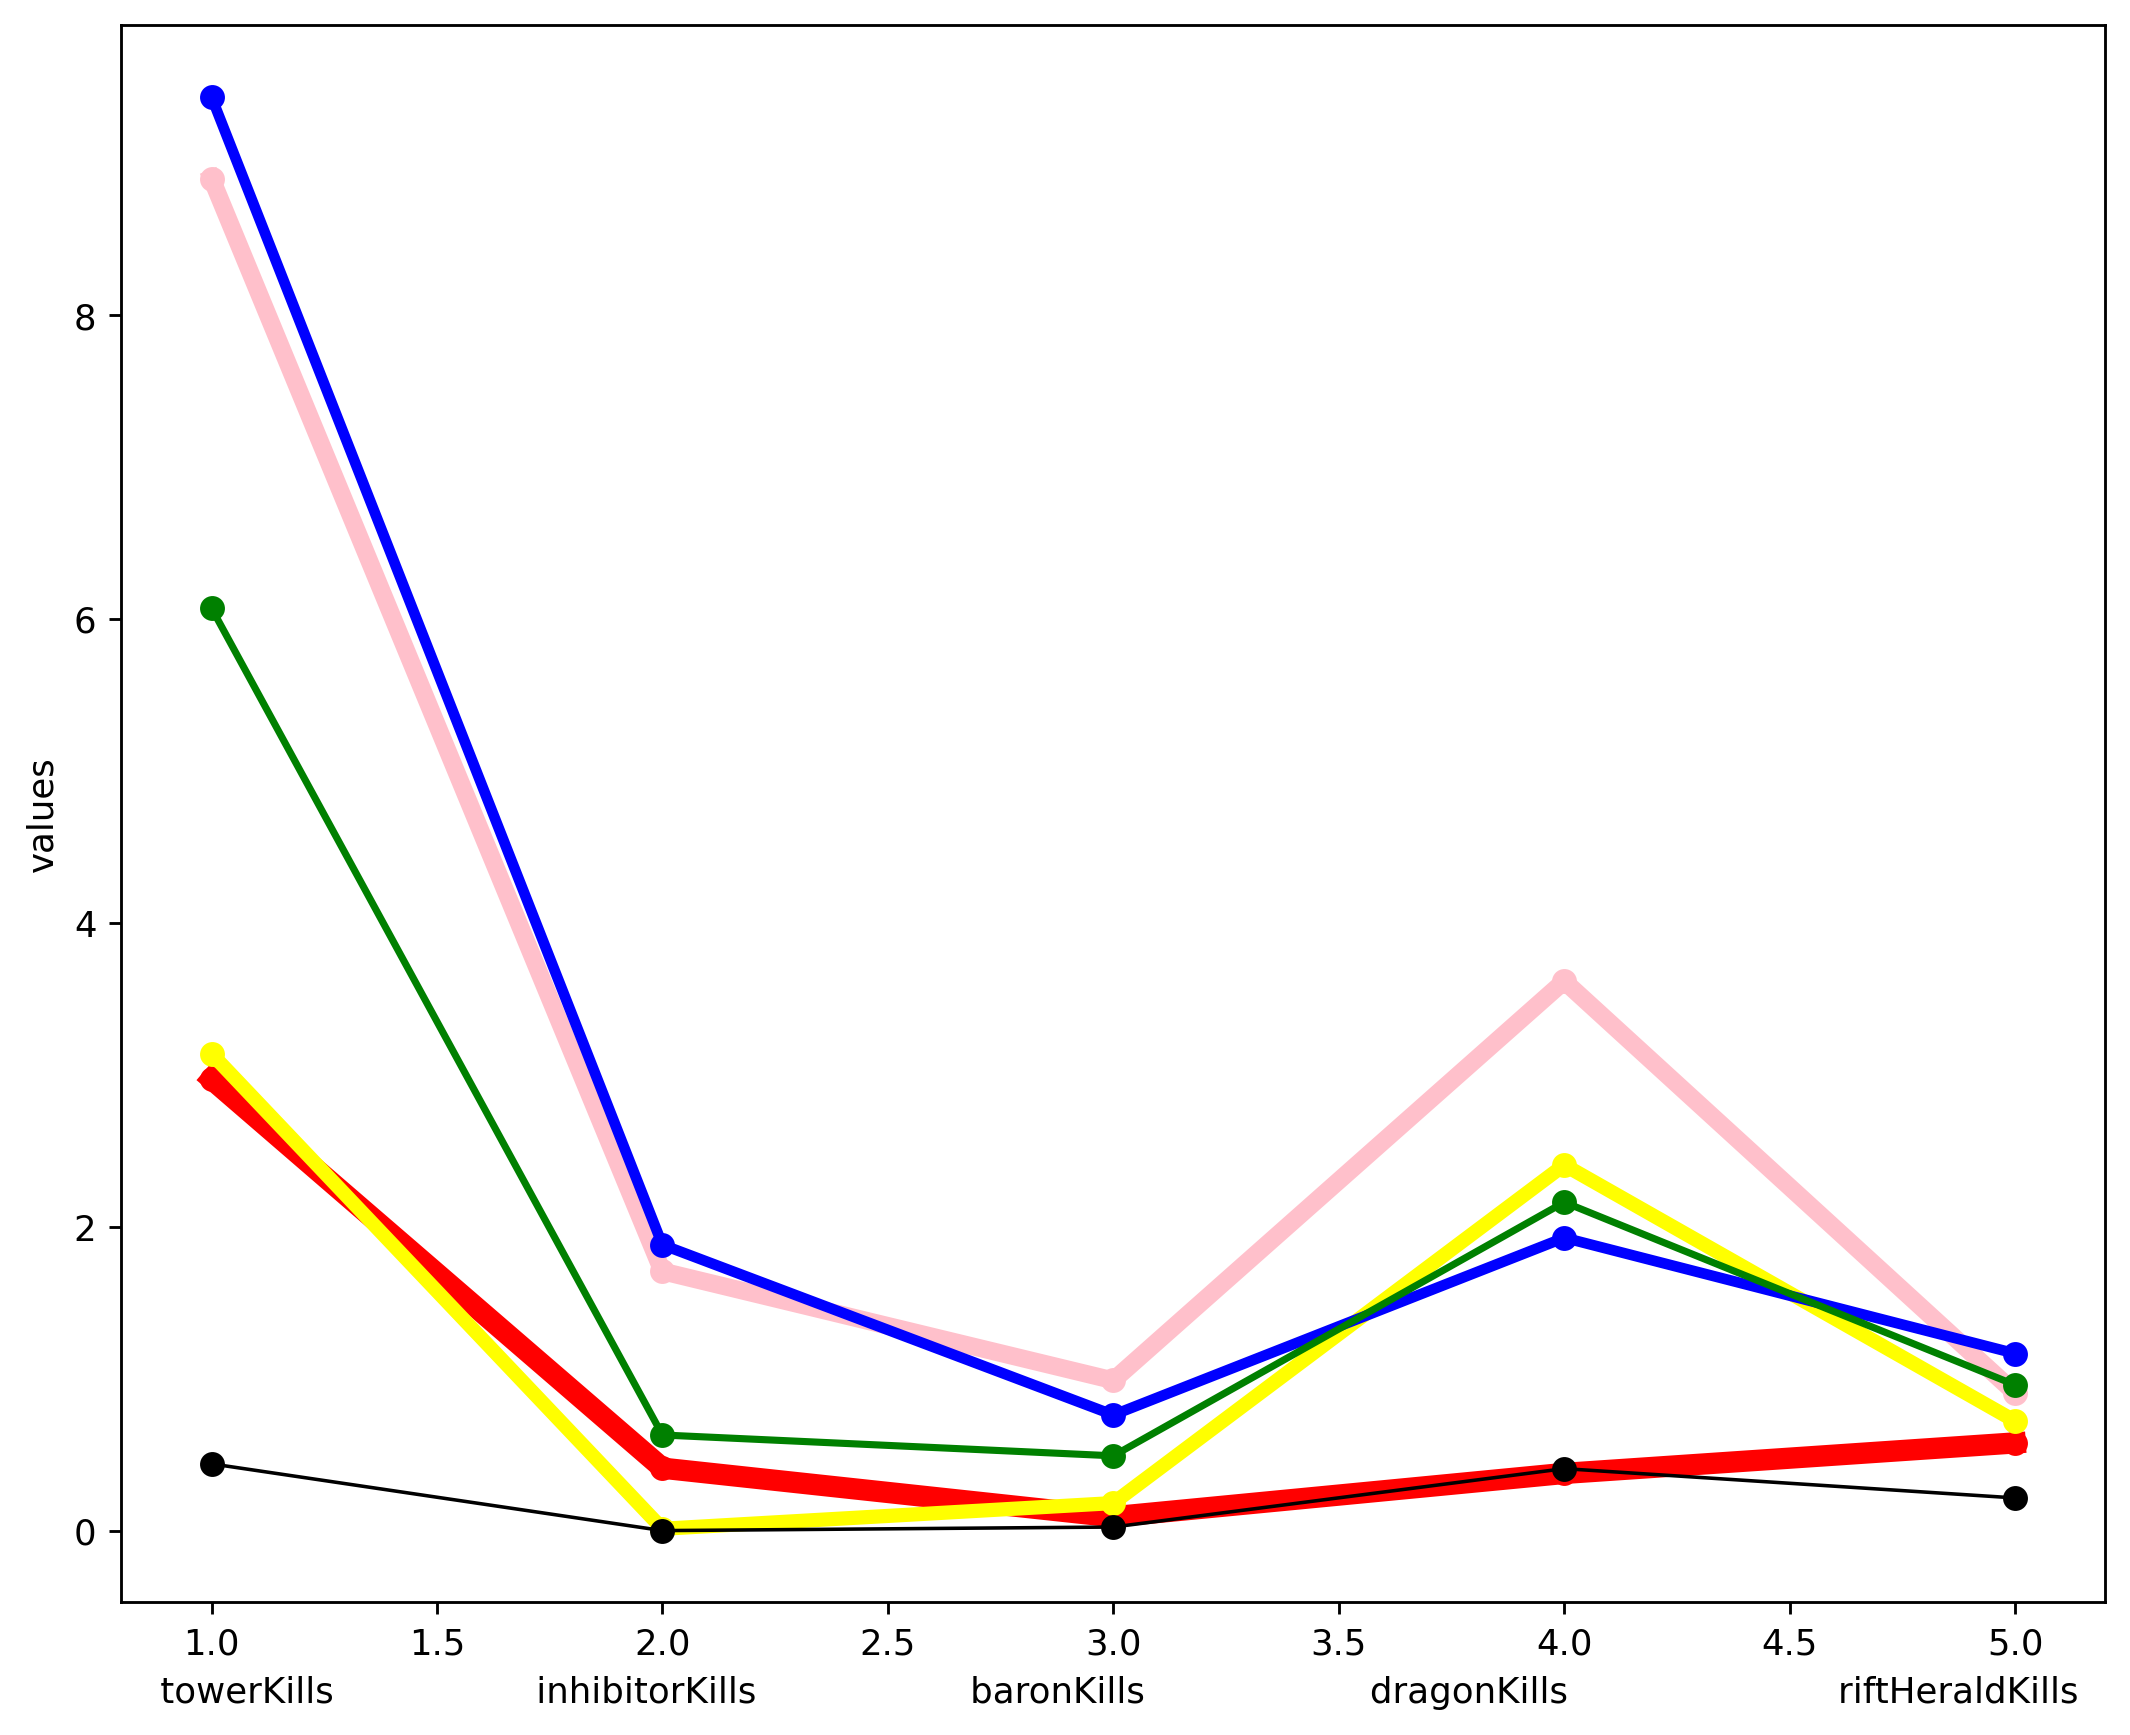

In [48]:
#特征折线图
x=[1,2,3,4,5]
colors = ['red','pink','yellow','blue','green','black']
fig = plt.figure(figsize=(10,8), dpi=256)  # 指定绘图对象宽度和高度
for i in range(6):
    plt.plot(x,kmeans_center[i],label = 'type'+str(i),linewidth = 6-i,color = colors[i],
             marker = 'o')
plt.xlabel(' towerKills                  inhibitorKills                   baronKills                    dragonKills                        riftHeraldKills')
plt.ylabel('values') 
plt.show()
